### Generating fake images of items using Fashion MNIST

Tutorial available at:
https://github.com/tomsercu/gan-tutorial-pytorch/blob/master/2019-04-23%20GAN%20Tutorial.ipynb

In [2]:
import sys
print(sys.version) # python 3.6
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
print(torch.__version__) # 1.0.1

%matplotlib inline
import matplotlib.pyplot as plt

def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
1.0.1.post2


### Discriminator and Generator

In [3]:
class Discriminator(torch.nn.Module):
    def __init__(self, inp_dim=784):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(inp_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = x.view(x.size(0), 784) # flatten (bs x 1 x 28 x 28) -> (bs x 784)
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.sigmoid(out)
        return out

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.nonlin1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128, 784)
    def forward(self, x):
        h = self.nonlin1(self.fc1(x))
        out = self.fc2(h)
        out = torch.tanh(out) # range [-1, 1]
        # convert to image 
        out = out.view(out.size(0), 1, 28, 28)
        return out

In [5]:
# instantiate a Generator and Discriminator according to their class definition.
D = Discriminator()
print(D)
G = Generator()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
)


### Loading the data and computing forward pass 

In [6]:
# let's download the Fashion MNIST data, if you do this locally and you downloaded before,
# you can change data paths to point to your existing files
# dataset = torchvision.datasets.MNIST(root='./MNISTdata', ...)
dataset = torchvision.datasets.FashionMNIST(root='./FashionMNIST/',
                       transform=transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize((0.5,), (0.5,))]),
                       download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

100%|█████████▉| 26419200/26421880 [02:48<00:00, 136948.57it/s] 

Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz



0it [00:00, ?it/s]


 56%|█████▌    | 16384/29515 [00:00<00:00, 80843.21it/s]
32768it [00:00, 41468.41it/s]                           
0it [00:00, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz



 13%|█▎        | 581632/4422102 [00:10<01:06, 57493.78it/s]
26427392it [03:00, 136948.57it/s]                              
 61%|██████    | 2686976/4422102 [00:35<00:23, 72618.92it/s]


100%|█████████▉| 4407296/4422102 [00:57<00:00, 60724.36it/s]
4423680it [00:57, 73606.64it/s]                             

0it [00:00, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz




  0%|          | 0/5148 [00:00<?, ?it/s]

8192it [00:00, 12525.82it/s]            

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


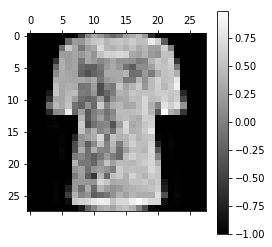

In [7]:
ix=149
x, _ = dataset[ix]
plt.matshow(x.squeeze().numpy(), cmap=plt.cm.gray)
plt.colorbar()

In [8]:
# for one image:
Dscore = D(x)
Dscore

tensor([[0.5462]], grad_fn=<SigmoidBackward>)

In [9]:
# How you can get a batch of images from the dataloader:
xbatch, _ = iter(dataloader).next() # 64 x 1 x 28 x 28: minibatch of 64 samples
xbatch.shape
D(xbatch) # 64x1 tensor: 64 predictions of probability of input being real.
D(xbatch).shape

torch.Size([64, 1])


4423680it [01:10, 73606.64it/s]

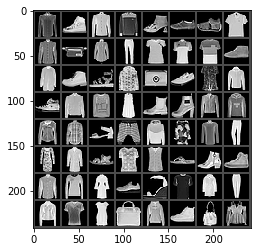

In [10]:
show_imgs(xbatch)

In [11]:
# Remember we have defined the discriminator and generator as:
D = Discriminator()
print(D)
G = Generator()
print(G)
# Now let's set up the optimizers
optimizerD = torch.optim.SGD(D.parameters(), lr=0.01)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.01)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (nonlin1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=784, bias=True)
)


In [12]:
# and the BCE criterion which computes the loss above:
criterion = nn.BCELoss()

In [13]:
# STEP 1: Discriminator optimization step
x_real, _ = iter(dataloader).next()
lab_real = torch.ones(64, 1)
lab_fake = torch.zeros(64, 1)
# reset accumulated gradients from previous iteration
optimizerD.zero_grad()

D_x = D(x_real)
lossD_real = criterion(D_x, lab_real)

z = torch.randn(64, 100) # random noise, 64 samples, z_dim=100
x_gen = G(z).detach()
D_G_z = D(x_gen)
lossD_fake = criterion(D_G_z, lab_fake)

lossD = lossD_real + lossD_fake
lossD.backward()
optimizerD.step()

# print(D_x.mean().item(), D_G_z.mean().item())

In [17]:
# STEP 2: Generator optimization step
# note how only one of the terms involves the Generator so this is the only one that matters for G.
# reset accumulated gradients from previous iteration
optimizerG.zero_grad()

z = torch.randn(64, 100) # random noise, 64 samples, z_dim=100
D_G_z = D(G(z))
lossG = criterion(D_G_z, lab_real) # -log D(G(z))

lossG.backward()
optimizerG.step()

print(D_G_z.mean().item())

0.49943840503692627


Device:  cpu
e0.i0/938 last mb D(x)=0.4868 D(G(z))=0.4780
e0.i100/938 last mb D(x)=0.9406 D(G(z))=0.3440
e0.i200/938 last mb D(x)=0.9461 D(G(z))=0.1674
e0.i300/938 last mb D(x)=0.9464 D(G(z))=0.1276
e0.i400/938 last mb D(x)=0.9506 D(G(z))=0.0753
e0.i500/938 last mb D(x)=0.9538 D(G(z))=0.0335
e0.i600/938 last mb D(x)=0.7628 D(G(z))=0.3540
e0.i700/938 last mb D(x)=0.8617 D(G(z))=0.1542
e0.i800/938 last mb D(x)=0.9348 D(G(z))=0.0791
e0.i900/938 last mb D(x)=0.7778 D(G(z))=0.3244
e1.i0/938 last mb D(x)=0.7359 D(G(z))=0.2023
e1.i100/938 last mb D(x)=0.7926 D(G(z))=0.2479
e1.i200/938 last mb D(x)=0.7048 D(G(z))=0.3631
e1.i300/938 last mb D(x)=0.8615 D(G(z))=0.1315
e1.i400/938 last mb D(x)=0.7730 D(G(z))=0.2044
e1.i500/938 last mb D(x)=0.6487 D(G(z))=0.3850
e1.i600/938 last mb D(x)=0.6999 D(G(z))=0.3727
e1.i700/938 last mb D(x)=0.5663 D(G(z))=0.4443
e1.i800/938 last mb D(x)=0.9236 D(G(z))=0.0913
e1.i900/938 last mb D(x)=0.9283 D(G(z))=0.0524
e2.i0/938 last mb D(x)=0.8700 D(G(z))=0.1606
e2.i10

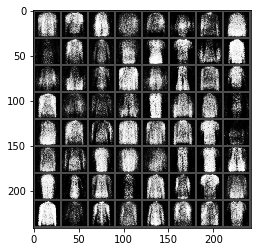

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device: ', device)
# Re-initialize D, G:
D = Discriminator().to(device)
G = Generator().to(device)
# Now let's set up the optimizers (Adam, better than SGD for this)
optimizerD = torch.optim.SGD(D.parameters(), lr=0.03)
optimizerG = torch.optim.SGD(G.parameters(), lr=0.03)
# optimizerD = torch.optim.Adam(D.parameters(), lr=0.0002)
# optimizerG = torch.optim.Adam(G.parameters(), lr=0.0002)
lab_real = torch.ones(64, 1, device=device)
lab_fake = torch.zeros(64, 1, device=device)


# for logging:
collect_x_gen = []
fixed_noise = torch.randn(64, 100, device=device)
fig = plt.figure() # keep updating this one
plt.ion()

for epoch in range(3): # 10 epochs
    for i, data in enumerate(dataloader, 0):
        # STEP 1: Discriminator optimization step
        x_real, _ = iter(dataloader).next()
        x_real = x_real.to(device)
        # reset accumulated gradients from previous iteration
        optimizerD.zero_grad()

        D_x = D(x_real)
        lossD_real = criterion(D_x, lab_real)

        z = torch.randn(64, 100, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z).detach()
        D_G_z = D(x_gen)
        lossD_fake = criterion(D_G_z, lab_fake)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()
        
        # STEP 2: Generator optimization step
        # reset accumulated gradients from previous iteration
        optimizerG.zero_grad()

        z = torch.randn(64, 100, device=device) # random noise, 64 samples, z_dim=100
        x_gen = G(z)
        D_G_z = D(x_gen)
        lossG = criterion(D_G_z, lab_real) # -log D(G(z))

        lossG.backward()
        optimizerG.step()
        if i % 100 == 0:
            x_gen = G(fixed_noise)
            show_imgs(x_gen, new_fig=False)
            fig.canvas.draw()
            print('e{}.i{}/{} last mb D(x)={:.4f} D(G(z))={:.4f}'.format(
                epoch, i, len(dataloader), D_x.mean().item(), D_G_z.mean().item()))
    # End of epoch
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

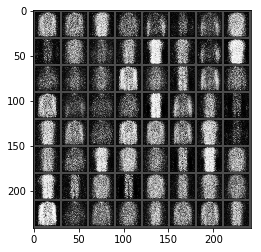

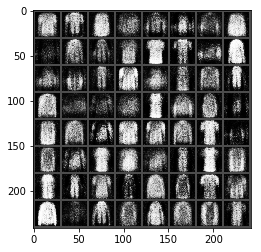

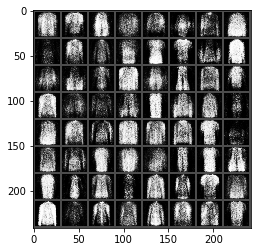

In [19]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)